# Import Library

In [17]:
# Library
import random
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Kumpulan Fungsi

In [3]:
import math

def haversine(lat1:int|float, lon1:int|float, lat2:int|float, lon2:int|float):
    R = 6372.8  # Radius Bumi
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    distance = R * c
    return distance

populasi

In [4]:
def generate_populasi(guru:pd.DataFrame, sekolah:pd.DataFrame, jarak:pd.DataFrame, num_kromosom:int = 10):
    generated = []
    for _ in (pbar := tqdm(range(num_kromosom))):
        pbar.set_description(f"generate populasi")
        guru = guru.sample(frac=1) # Mengacak urutan data
        temp = [[_ for _ in range(3)] for _ in range(len(guru))] # Penyimpanan sementara

        i_guru = 0
        for i,x in enumerate(sekolah.values):
            for _ in range(6): # Membuat sebanyak 6 rombongan belajar
                id_sekolah  = x[0]
                id_guru     = guru.values[i_guru][0]
                
                temp[i_guru][0] = x[0]
                temp[i_guru][1] = id_guru
                temp[i_guru][2] = jarak.loc[(jarak["ID_GURU"] == id_guru) & (jarak["ID_SEKOLAH"] == id_sekolah),"JARAK"].iloc[0]
                
                i_guru += 1

        generated.append(pd.DataFrame(temp,columns=["id_sekolah","id_guru","jarak"]))
    
    return generated
    

Fitness

In [5]:
def generate_fitness(kromosom:pd.DataFrame):
    generated = np.zeros((len(kromosom),2))
    for i,x in enumerate(kromosom):
        generated[i][0] = x.iloc[:,2].sum()
    generated[:,1] = generated[:,0] - (1.5 * generated[:,0].max())
    return pd.DataFrame(generated,columns=['jarak','fitness'])

roulette wheel

In [6]:
def roulette_wheel(kromosom:pd.DataFrame,fitness:pd.DataFrame,max_iteration:int=100):
    fitness['prob_selection'] = fitness['fitness']/fitness['fitness'].sum()
    probability = np.cumsum(fitness['prob_selection'])  
    random_value = [random.random() for _ in range(max_iteration)]

    selected = []
    for rV in random_value:
        for i in  range(len(probability)):
            if rV < probability[i]:
                selected.append(kromosom[i])
                break

    return selected


crossover

In [7]:
def crossover(parent1:pd.DataFrame,parent2:pd.DataFrame, point = random.randint(0, 635)):
    child1, child2 = parent1.copy(), parent2.copy()
    child1_left, child1_right = child1.values[:point], child1.values[point:]
    child2_left, child2_right = child2.values[:point], child2.values[point:]
    child1[:] = np.concatenate((child1_left, child2_right))
    child2[:] = np.concatenate((child1_right, child2_left))
    return child1, child2

mutasi

In [60]:
def mutasi(kromosom:pd.DataFrame, type:str = 'insert'):
    type = type.lower()
    mutan = kromosom.copy()
    random_idx = random.sample(range(0, len(kromosom)-1),2)
    
    if type is 'insert':
        value = mutan.values[random_idx[0]]
        mutan_ = np.delete(mutan.values, random_idx[0], axis=0)
        mutan_ = np.insert(mutan_, random_idx[1], value, axis=0)
        mutan[:] = mutan_

    if type is 'swap':
        data1, data2 = mutan.iloc[random_idx[0]], mutan.iloc[random_idx[1]]
        mutan.iloc[random_idx[0]], mutan.iloc[random_idx[1]] = data2, data1
        
    return mutan

replace kromosom

In [9]:
def replace_kromosom(kromosom:pd.DataFrame,fitness:pd.DataFrame,children:pd.DataFrame):
    fitness_value = fitness.copy()
    data = kromosom.copy()
    child_copy = children.copy()

    fit_sum = fitness_value['fitness'].sum()
    fit_max = 1.5 * fitness_value['jarak'].max()
    child_fit = pd.DataFrame()

    for i in range(len(child_copy)):
        child_fit = child_fit.append({'jarak': child_copy[i].T.sum(axis=1).iloc[2], \
        'fitness': child_copy[i].T.sum(axis=1).iloc[2] - fit_max}, ignore_index=True)
    
    for i in range(len(child_copy)):
        index_max, max = fitness_value['jarak'].idxmax() ,fitness_value['jarak'].max()
        new = child_fit['jarak'].iloc[i]
        if new < max:
            fitness_value.iloc[index_max,:-1] = child_fit.iloc[i]
            data[index_max] = child_copy[i]

    return fitness_value, data

genetic algorithm

In [10]:
def genetic_algorithm(guru, sekolah, jarak, iterasi, n_kromosom, prob_mutasi):
    populasi = generate_populasi(guru, sekolah, jarak, n_kromosom)
    fitness = generate_fitness(populasi)

    min = pd.DataFrame()
    children = []

    for i in (pbar := tqdm(range(iterasi))):
        pbar.set_description(f"genetic algorithm...{i % prob_mutasi}")
        if i % prob_mutasi == 0:
            parent = roulette_wheel(populasi,fitness,2)

            child1, child2 = crossover(parent[0],parent[1])

            children = [*children, child1, child2]
        else:
            kromosom = roulette_wheel(populasi,fitness,1)[0]
            mutan = mutasi(kromosom)
            children.append(mutan)

        
        new_fit, new_data = replace_kromosom(populasi,fitness,children)
        fitness, populasi = new_fit, new_data

        id_min = fitness['fitness'].idxmin()
        min = min.append(fitness.loc[id_min], ignore_index=True)

        children.clear()

    return min, kromosom


## Membaca Data

In [11]:
data_sekolah = pd.read_excel('ds.xlsx')
data_guru = pd.read_excel('dg.xlsx')

In [12]:
data_sekolah

,id,nama,rombel,lats,longs
0,45,SD NEGERI NGARGOGONDO,6,-7.6263,110.2094
1,48,SD NEGERI RINGINPUTIH 3,6,-7.5994,110.1963
2,51,SD NEGERI TANJUNGSARI,6,-7.6171,110.1974
3,56,SD NEGERI BENINGAN,6,-7.5154,110.2900
4,67,SD NEGERI PODOSOKO,6,-7.5183,110.2568
...,...,...,...,...,...
101,509,SDN MANGUNREJO,6,-7.4395,110.3089
102,528,SD NEGERI TEMANGGAL,6,-7.5285,110.1533
103,541,SD NEGERI KEMBANGKUNING 1,6,-7.4036,110.1305
104,551,SD NEGERI WINDUSARI 1,6,-7.4019,110.1647


### Menyimpan data jarak antara guru dan sekolah menggunakan haversine

In [13]:
kolom_jarak = ["ID_GURU","ID_SEKOLAH","JARAK"]
data_jarak = []
for i,x in enumerate(data_guru.values):
  for j,y in enumerate(data_sekolah.values):
    data_jarak.append([x[0],y[0],haversine(x[3],x[4],y[3],y[4])])
data_jarak = pd.DataFrame(data_jarak,columns=kolom_jarak)
data_jarak.to_csv('data_jarak.tsv',sep="\t",index=False)

### Implementasi Genetic Algorithm

In [96]:
# Parameter Masukan
N_KROMOSOM = 30
MAX_ITERATION = 1000
PROB_MUTATION = 2
min, kromosom = genetic_algorithm(data_guru, data_sekolah, data_jarak, MAX_ITERATION, N_KROMOSOM, PROB_MUTATION)

genetic algorithm...1: 100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


In [97]:
min

,jarak,fitness,prob_selection
0,12089.141144,-6935.332220,0.034676
1,12089.141144,-6935.332220,0.034629
2,12089.141144,-6935.332220,0.034571
3,12089.141144,-6935.332220,0.034554
4,12089.141144,-6935.332220,0.034524
...,...,...,...
995,9057.225113,-4939.322173,0.035236
996,9057.225113,-4939.322173,0.035236
997,9057.225113,-4939.322173,0.035236
998,9057.225113,-4939.322173,0.035236


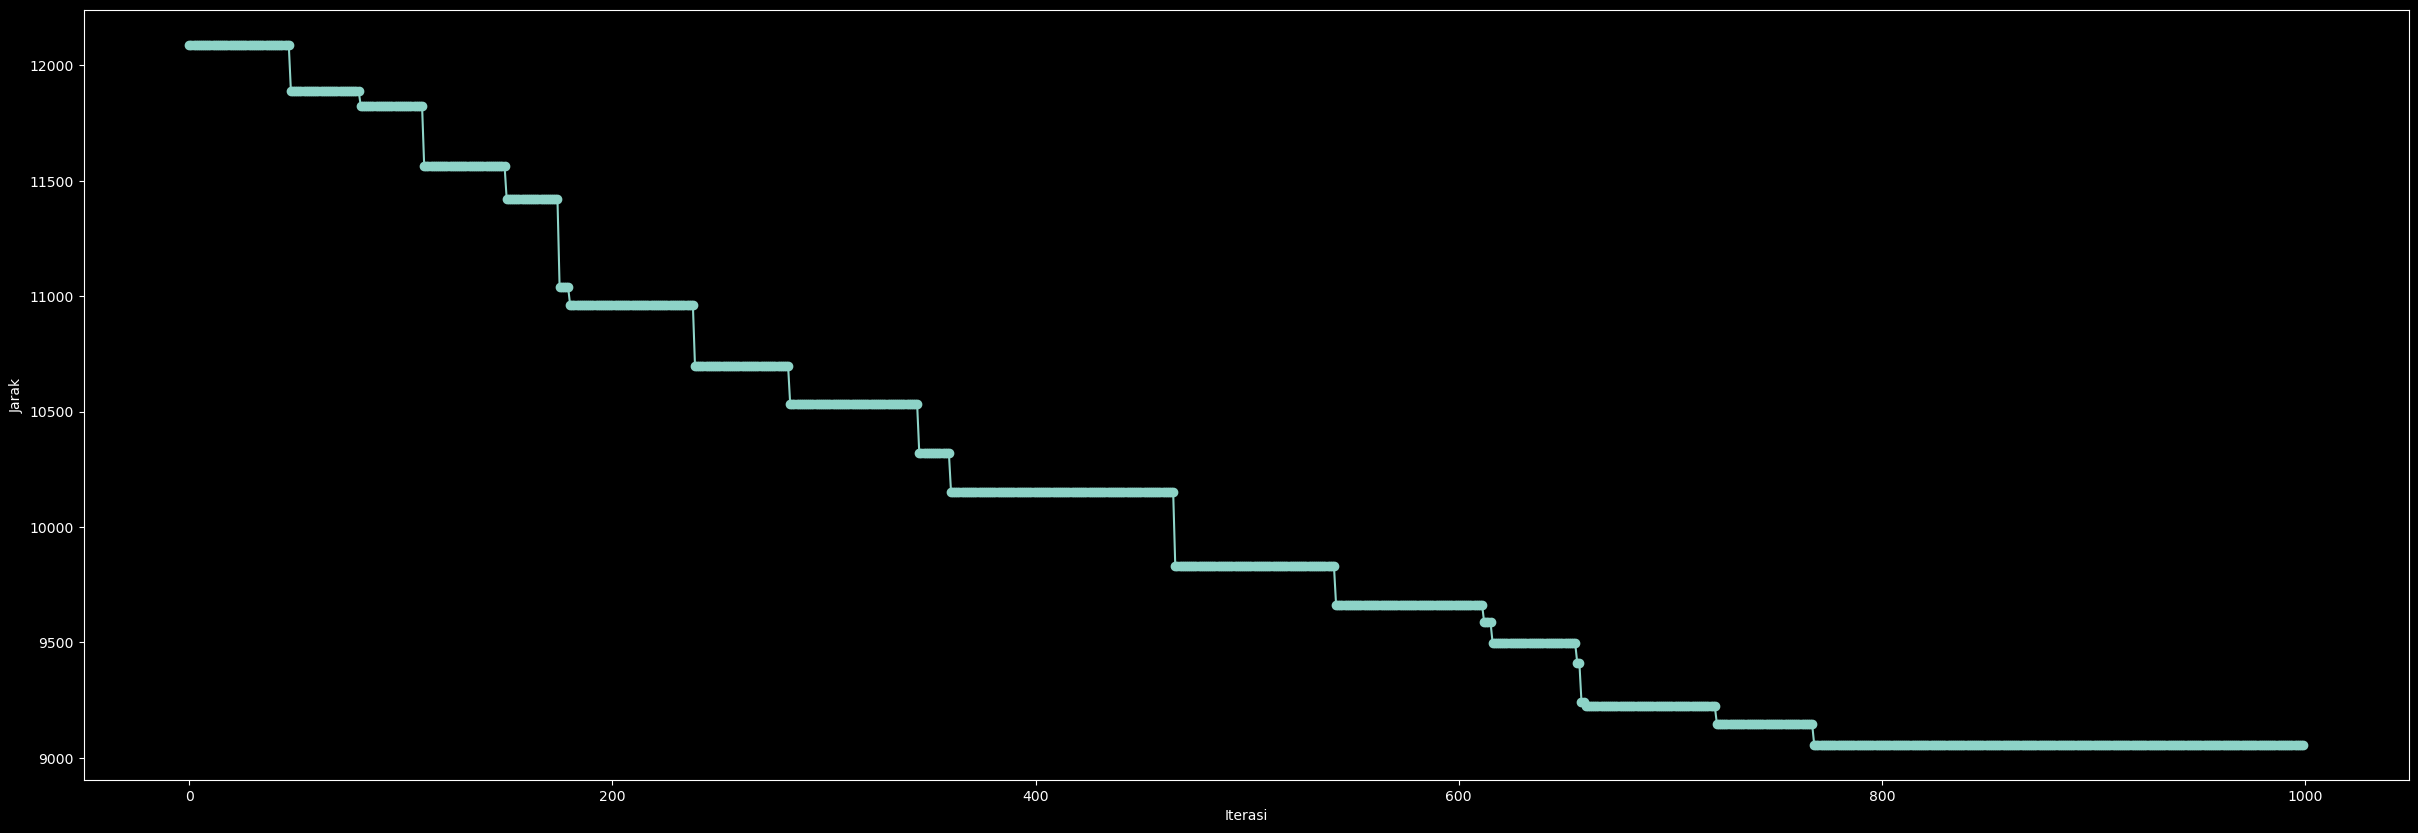

In [98]:
plt.xlabel("Iterasi")
plt.ylabel("Jarak")
plt.gcf().set_size_inches((30,10))
plt.plot(min['jarak'],marker='o')